# Tuning of Hyperparameters in Simple Self-EFficacy Learner Model

This notebook includes code from iterating on the Self-Efficacy Learner Behavior Model including hyperparameters for generating the set of learners in the population.

In [1]:
import sys
sys.path.append("../lib")

In [2]:
import logging
import random
import uuid
import os
from collections.abc import Iterable

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from tutor.domain import Domain
from tutor.cogtutor_curriculum import CogTutorCurriculum
from tutor.tutor import SimpleTutor
from tutor.action import Attempt, HintRequest
from learner.selfeff_learner import SelfEfficacyLearner


from simulate.self_eff_simulation import SelfEffSimulation
from log_db import mongo
from log_db.curriculum_mapper import DB_Curriculum_Mapper


In [4]:
#logging.basicConfig(level=logging.DEBUG)
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("main")

In [5]:
#logging.getLogger().setLevel(logging.DEBUG)
logging.getLogger().setLevel(logging.INFO)
#logging.getLogger().setLevel(logging.WARNING)
logger.debug("Test debug")
logger.info("Test info")
logger.warning("Test warning")

INFO:main:Test info


In [6]:
# Get path to current project directory
cwd = os.path.abspath(".")
base_dir = os.path.abspath(os.path.join(cwd, os.pardir))
logger.debug("Base directory for the project:\n%s" % base_dir)

In [7]:
# Setup connection to database
data_out = "sim-%s" % str(uuid.uuid4())
data_path = os.path.join(base_dir,"test", "data", data_out)
logger.info("Writing simulation results to directory: %s" % data_path)
db_name = "motivsim"
db_params  = mongo.get_db_params(db_name)
logger.info("got db params: %s" % str(db_params))
db_util = mongo.Data_Utility(data_path, db_params)
db = db_util.db

INFO:main:Writing simulation results to directory: /rdata/Sandbox/MotivSim/test/data/sim-9bfecdea-8b68-4c43-ba24-8fde5920de2d
INFO:main:got db params: {'settingId': 'motivsim', 'url': 'localhost', 'port': '27017', 'name': 'motivsim', 'user': '', 'pswd': ''}


In [8]:
logger.info("Clearing database before starting new simulation")
db_util.clear_db()

INFO:main:Clearing database before starting new simulation
INFO:log_db.mongo:Clearing all documents from collection kcs
INFO:log_db.mongo:Clearing all documents from collection domains
INFO:log_db.mongo:Clearing all documents from collection students
INFO:log_db.mongo:Clearing all documents from collection units
INFO:log_db.mongo:Clearing all documents from collection decisions
INFO:log_db.mongo:Clearing all documents from collection curriculums
INFO:log_db.mongo:Clearing all documents from collection steps
INFO:log_db.mongo:Clearing all documents from collection finalsimstudents
INFO:log_db.mongo:Clearing all documents from collection problems
INFO:log_db.mongo:Clearing all documents from collection actions
INFO:log_db.mongo:Clearing all documents from collection sections
INFO:log_db.mongo:Clearing all documents from collection tutor_events


## Generating Learners

### Setting up Simulation

In [9]:
# Generating empty domain
domain = Domain()
domain_params = {
    'm_l0': 0.45,
    'sd_l0': 0.155,
    'm_t': 0.35,
    'sd_t': 0.13,#0.03,
    'm_s': 0.155,
    'sd_s': 0.055,
    'm_g': 0.45,#0.6,
    'sd_g': 0.105 
}
domain.set_kc_hyperparams(**domain_params)

In [10]:
# Generating the Curriculum and domain together

curric = CogTutorCurriculum(domain)
curric.generate(num_units=30,
               mean_sections=4,
               stdev_sections=2,
               mean_unit_kcs=22,
               stdev_unit_kcs=23,
               section_kcs_lambda=6,
               mean_steps=10,
               stdev_steps=4,
               mean_prob_kcs=6,
               stdev_prob_kcs=3,
               num_practice=400)


INFO:tutor.cogtutor_curriculum:Generated 30 units with with a total of 640 kcs


KeyboardInterrupt: 

In [ ]:
# Insert domain to db
db.domains.insert_one(domain.to_dict())
db.kcs.insert_many([kc.__dict__ for kc in domain.kcs])

# Insert Curriculum to db
curric_util = DB_Curriculum_Mapper(db_params)
curric_util.write_to_db(curric)

### Initializing Learners

In [ ]:
num_students = 30
students = [SelfEfficacyLearner(domain) for i in range(num_students)]
logger.info("Sample student:\n%s" % str(students[0]))
logger.info("Inserting %i students to db" % len(students))
result = db.students.insert_many([stu.to_dict() for stu in students])
logger.info("Db insert success: %s" % result.acknowledged)

### Simulating Learners

In [13]:
for i, stu in enumerate(students):
    logger.info("Simulating student #%i" % i)
    sim = SelfEffSimulation(domain, curric, stu)
    sim.run()

INFO:main:Simulating student #0
INFO:simulate.simulation:Starting simulation. Logging student into new session
INFO:tutor.tutor:Completed last unit. No more units in curriculum
INFO:simulate.simulation:Ending simulation. Logging out of active session
INFO:main:Simulating student #1
INFO:simulate.simulation:Starting simulation. Logging student into new session
INFO:tutor.tutor:Completed last unit. No more units in curriculum
INFO:simulate.simulation:Ending simulation. Logging out of active session
INFO:main:Simulating student #2
INFO:simulate.simulation:Starting simulation. Logging student into new session
INFO:tutor.tutor:Completed last unit. No more units in curriculum
INFO:simulate.simulation:Ending simulation. Logging out of active session
INFO:main:Simulating student #3
INFO:simulate.simulation:Starting simulation. Logging student into new session
INFO:tutor.tutor:Completed last unit. No more units in curriculum
INFO:simulate.simulation:Ending simulation. Logging out of active sess

In [14]:
logger.info("Inserting %i simulated students to db" % len(students))
db.finalsimstudents.insert_many([stu.to_dict() for stu in students])
logger.info("Db insert success: %s" % result.acknowledged)

INFO:main:Inserting 30 simulated students to db
INFO:main:Db insert success: True


In [15]:
#db_util.dump_db()

## EDA of simulated Data

In [16]:
# List size of all collections
db_util.peak()

INFO:log_db.mongo:collection name, kcs, has 818 documents
INFO:log_db.mongo:collection name, domains, has 1 documents
INFO:log_db.mongo:collection name, students, has 30 documents
INFO:log_db.mongo:collection name, units, has 30 documents
INFO:log_db.mongo:collection name, decisions, has 545490 documents
INFO:log_db.mongo:collection name, curriculums, has 1 documents
INFO:log_db.mongo:collection name, steps, has 357639 documents
INFO:log_db.mongo:collection name, finalsimstudents, has 30 documents
INFO:log_db.mongo:collection name, problems, has 88225 documents
INFO:log_db.mongo:collection name, actions, has 545490 documents
INFO:log_db.mongo:collection name, sections, has 140 documents
INFO:log_db.mongo:collection name, tutor_events, has 470090 documents


In [17]:
# look at number of students in tutor_events
#tx = pd.DataFrame([evt for evt in db['tutor_events'].find({'type': "Tutor Input"})])
#logger.info(tx.shape)
#logger.info(tx.groupby('stu_id')['_id'].count())

### Domain & Cirriculum EDA

In [18]:
'''
For recovering curriculum from db if running this script 
without newly generated curriculum

''' 


#result = db.curriculums.find()
#curriculums = [c for c in result]
#print(len(curriculums))
#cid = curriculums[0]['_id']
#curric_d = curriculums[0]
#print("curriculum id: %s" % cid)

'\nFor recovering curriculum from db if running this script \nwithout newly generated curriculum\n\n'

In [19]:
#curric_util = DB_Curriculum_Mapper(db_params)
#curric = curric_util.get_from_db(cid)
#print(str(curric))

In [20]:
kc_counts = []
prob_counts = []
for j, unit in enumerate(curric.units):
    logger.info("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$")
    logger.info("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$")
    logger.info("Unit #%i" % j)
    for i, section in enumerate(unit.sections):
        logger.info("##########################################")
        logger.info("Section #%i: %s" % (i, section._id))
        logger.info("Number of kcs: %i" % len(section.kcs))
        kc_counts.append(len(section.kcs))
        logger.info("Number of Problems: %i" % len(section.problems))
        prob_counts.append(len(section.problems))
        step_counts = [len(prob.steps) for prob in section.problems]
        
        step_dist = {val: step_counts.count(val) for val in set(step_counts)}
        logger.info("Distribution of steps across problems: %s" % str(step_dist))
    
kc_dist = {val: kc_counts.count(val) for val in set(kc_counts)}
prob_dist = {val: prob_counts.count(val) for val in set(prob_counts)}
logger.info("------------------- Total Curric stats --------------------------")
logger.info("Distribution of kcs per section: %s" % str(kc_dist))
logger.info("Distribution of prob per section: %s" % str(prob_dist))

INFO:main:$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
INFO:main:$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
INFO:main:Unit #0
INFO:main:##########################################
INFO:main:Section #0: 2649cdbc-2676-4ffe-8e62-fd8c2544444d
INFO:main:Number of kcs: 1
INFO:main:Number of Problems: 93
INFO:main:Distribution of steps across problems: {1: 11, 2: 8, 3: 16, 4: 13, 5: 16, 6: 13, 7: 10, 8: 4, 9: 2}
INFO:main:##########################################
INFO:main:Section #1: ca49e872-e94b-452f-9e9b-0747d8ddb1db
INFO:main:Number of kcs: 3
INFO:main:Number of Problems: 297
INFO:main:Distribution of steps across problems: {1: 34, 2: 31, 3: 50, 4: 57, 5: 61, 6: 24, 7: 25, 8: 10, 9: 4, 10: 1}
INFO:main:##########################################
INFO:main:Section #2: 4dd9ed89-d3af-42c2-a762-55c955e5fe76
INFO:main:Number of kcs: 22
INFO:main:Number of Problems: 2546
INFO:main:Distribution of steps across problems: {1: 277, 2: 306, 3: 439, 4: 471, 5: 450, 6: 312, 7: 180, 8: 79, 9: 24, 10: 8}


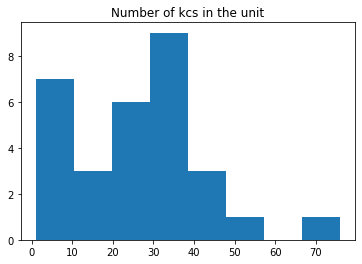

INFO:main:Total number of kcs: 818
INFO:main:count    30.000000
mean     27.266667
std      16.107255
min       1.000000
25%      15.750000
50%      28.000000
75%      34.000000
max      76.000000
dtype: float64


In [21]:
# Unit EDA
unit_kcs = [len(unit.kcs) for unit in curric.units]
plt.hist(unit_kcs, bins=8)
plt.title("Number of kcs in the unit")
plt.show()
logger.info("Total number of kcs: %i" % np.sum(unit_kcs))
logger.info(pd.Series(unit_kcs).describe())

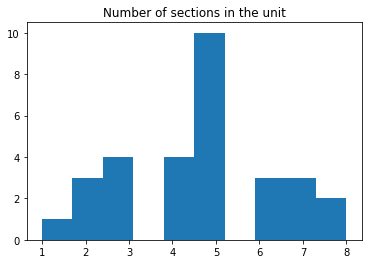

INFO:main:Total number of sections: 140
INFO:main:count    30.000000
mean      4.666667
std       1.787569
min       1.000000
25%       3.250000
50%       5.000000
75%       5.750000
max       8.000000
dtype: float64


In [22]:
#Section EDA
unit_sections = [len(unit.sections) for unit in curric.units]
plt.hist(unit_sections, bins=10)
plt.title("Number of sections in the unit")
plt.show()
logger.info("Total number of sections: %i" % np.sum(unit_sections))
logger.info(pd.Series(unit_sections).describe())

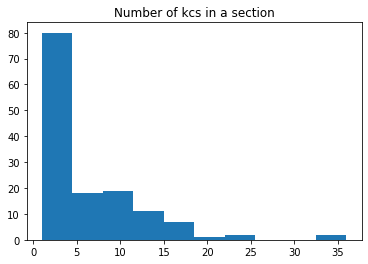

INFO:main:count    140.000000
mean       5.842857
std        6.056415
min        1.000000
25%        1.000000
50%        3.000000
75%        9.000000
max       36.000000
dtype: float64


In [23]:
section_kcs = []
for unit in curric.units:
    section_kcs.extend([len(section.kcs) for section in unit.sections])
plt.hist(section_kcs, bins=10)
plt.title("Number of kcs in a section")
plt.show()
logger.info(pd.Series(section_kcs).describe())

INFO:main:Distribution of steps per problems: 
1      9431.0
2     10643.0
3     15328.0
4     17389.0
5     15511.0
6     10612.0
7      5749.0
8      2484.0
9       804.0
10      218.0
11       48.0
12        8.0
dtype: float64


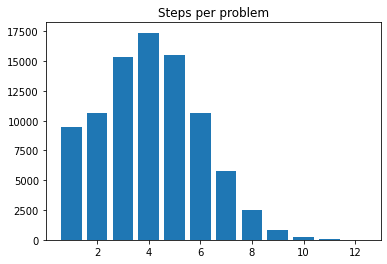

In [24]:
# steps per problem EDA
step_counts = []
for unit in curric.units:
    for section in unit.sections:
 #       logger.info("Section with %i kcs and %i problems" % (len(section.kcs), len(section.problems)))
        counts = pd.Series([len(prob.steps) for prob in section.problems]).value_counts()
#        logger.info("Counts of steps per problems \n%s" % str(counts))
        step_counts.append(counts)

    
prob_steps = pd.DataFrame(step_counts).sum(axis=0)
logger.info("Distribution of steps per problems: \n%s" %  str(prob_steps))
plt.bar(prob_steps.index, prob_steps)
plt.title("Steps per problem")
plt.show()

### Student EDA

In [25]:
logger.info("Getting pre-sim students")
presim_students = pd.DataFrame(db.students.find())
sim_students = pd.DataFrame(db.finalsimstudents.find())
sim_students.rename(columns={'skills': 'final skills', 
                             'total_attempts': 'final total attempts',
                             'total_success': 'final total success'}, inplace=True)

logger.info("pre-sim students: %s" % str(presim_students.shape))
logger.info("post-sim students: %s" % str(sim_students.shape))


sim_students = presim_students.merge(sim_students[['_id', 'final skills', 'final total attempts', 'final total success']], how='right', on=['_id'])
sim_students['pre-sim total mastery'] = sim_students.apply(lambda x: np.sum(list(x['skills'].values())), axis=1)
sim_students['final-sim total mastery'] = sim_students.apply(lambda x: np.sum(list(x['final skills'].values())), axis=1)
sim_students['total skills'] = sim_students.apply(lambda x: len(list(x['skills'].values())), axis=1)
sim_students['pre-sim pct mastery'] = sim_students.apply(lambda x: x['pre-sim total mastery'] / x['total skills'], axis=1)
sim_students['final-sim pct mastery'] = sim_students.apply(lambda x: x['final-sim total mastery'] / x['total skills'], axis=1)
sim_students['final-sim total unmastered'] = sim_students.apply(lambda x: x['total skills'] - x['final-sim total mastery'], axis=1)
sim_students['final self-eff'] = sim_students.apply(lambda x: ((x['self_eff'] * 100) + x['final total success']) / (500 + x['final total attempts']), axis=1)
sim_students['pct success'] = sim_students.apply(lambda x: x['final total success'] / x['final total attempts'], axis=1)
sim_students.head()

INFO:main:Getting pre-sim students
INFO:main:pre-sim students: (30, 13)
INFO:main:post-sim students: (30, 13)


,_id,domain_id,type,skills,min_off_task,max_off_task,mean_guess_time,sd_guess_time,diligence,self_eff,...,final total attempts,final total success,pre-sim total mastery,final-sim total mastery,total skills,pre-sim pct mastery,final-sim pct mastery,final-sim total unmastered,final self-eff,pct success
0,5332323f-0421-4dd1-b901-83091a8ac9a8,64fbb4fb-c233-4e12-b463-a780240e7a36,Self Efficacy Learner,{'219c53ea-ba56-4768-b9fb-affbf6a54aa0': False...,30,1200,3,1,1.812376,0.550383,...,13462,8857,377,806,818,0.460880,0.985330,12,0.638307,0.657926
1,581d09e0-be83-42b4-ad9c-7ed101ce0d66,64fbb4fb-c233-4e12-b463-a780240e7a36,Self Efficacy Learner,{'219c53ea-ba56-4768-b9fb-affbf6a54aa0': False...,30,1200,3,1,1.440692,0.440657,...,14626,9720,387,815,818,0.473105,0.996333,3,0.645515,0.664570
2,70ab2726-e587-4d52-be61-1673c47c0ddd,64fbb4fb-c233-4e12-b463-a780240e7a36,Self Efficacy Learner,"{'219c53ea-ba56-4768-b9fb-affbf6a54aa0': True,...",30,1200,3,1,2.394740,0.493820,...,11042,7389,398,808,818,0.486553,0.987775,10,0.644462,0.669172
3,3d0b70dd-c386-4edd-a8b8-2d3b8734c7c3,64fbb4fb-c233-4e12-b463-a780240e7a36,Self Efficacy Learner,{'219c53ea-ba56-4768-b9fb-affbf6a54aa0': False...,30,1200,3,1,1.999051,0.673845,...,14051,9148,369,812,818,0.451100,0.992665,6,0.633316,0.651057
4,944334f9-4356-495f-8620-95261c2e0b2d,64fbb4fb-c233-4e12-b463-a780240e7a36,Self Efficacy Learner,{'219c53ea-ba56-4768-b9fb-affbf6a54aa0': False...,30,1200,3,1,1.836901,0.445446,...,14250,9523,403,814,818,0.492665,0.995110,4,0.648647,0.668281


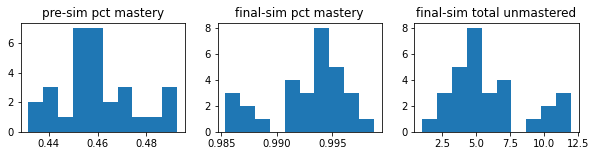

INFO:main:Total skills: 818


In [26]:
# Plot mastery
plt.figure(figsize=(10,2))
plt.subplot(131)
plt.hist(sim_students['pre-sim pct mastery'], bins=10)
plt.title("pre-sim pct mastery")

plt.subplot(132)
plt.hist(sim_students['final-sim pct mastery'], bins=10)
plt.title("final-sim pct mastery")

plt.subplot(133)
plt.hist(sim_students['final-sim total unmastered'], bins=10)
plt.title("final-sim total unmastered")

plt.show()
logger.info("Total skills: %i" % sim_students['total skills'][0])

0: attempt
1: guess
2: hint request
3: off task


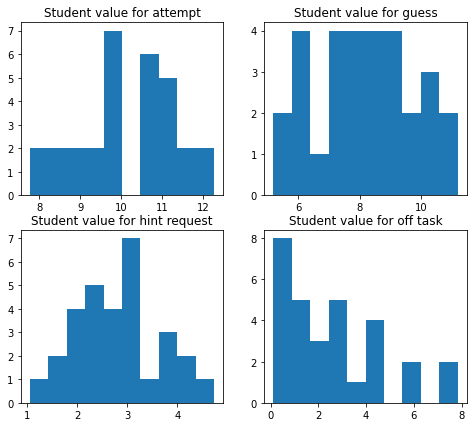

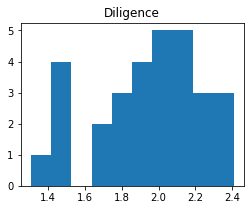

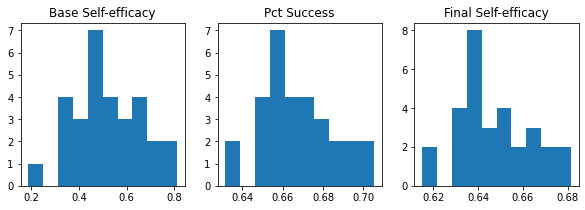

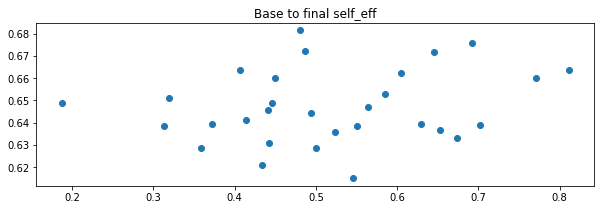

In [27]:
# Plot Values & Diligence
plt.figure(figsize=(8,7))
for i,val in enumerate(sim_students['values'][0].keys()):
    print("%i: %s" % (i, val))
    plt.subplot(2,2,i+1)
    plt.hist(sim_students['values'].apply(lambda x: x[val]), bins=10)
    plt.title('Student value for %s' % val)

plt.show()

plt.figure(figsize=(4,3))
plt.hist(sim_students['diligence'], bins=10)
plt.title("Diligence")
plt.show()

plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plt.hist(sim_students['self_eff'], bins=10)
plt.title("Base Self-efficacy")
plt.subplot(1,3,2)
plt.hist(sim_students['pct success'], bins=10)
plt.title("Pct Success")
plt.subplot(1,3,3)
plt.hist(sim_students['final self-eff'], bins=10)
plt.title("Final Self-efficacy")
plt.show()

plt.figure(figsize=(10,3))
plt.scatter(sim_students['self_eff'], sim_students['final self-eff'])
plt.title("Base to final self_eff")
plt.show()



### Learner Actions EDA

In [28]:
# Get Learner actions
actions = pd.DataFrame(db.actions.find())
actions['type'] = actions.apply(lambda x: x['action']['name'], axis=1)
actions['duration'] = actions.apply(lambda x: x['action']['time'], axis=1)
actions.head()

,_id,student_id,action,time,type,duration
0,c9abc4df-daea-411b-9e67-ae51c436952b,5332323f-0421-4dd1-b901-83091a8ac9a8,"{'name': 'Hint Request', 'time': 4.04426548586...",2020-11-13 20:04:40.524,Hint Request,4.044265
1,36c5f8e0-6322-46c1-869b-9204427244c2,5332323f-0421-4dd1-b901-83091a8ac9a8,"{'name': 'Hint Request', 'time': 1.57774555159...",2020-11-13 20:04:44.568,Hint Request,1.577746
2,d01fba12-72b0-4755-a256-9b49c311fc07,5332323f-0421-4dd1-b901-83091a8ac9a8,"{'name': 'Attempt', 'time': 23.857321712452226...",2020-11-13 20:04:46.146,Attempt,23.857322
3,5e3982e5-982d-4958-bf62-df7dc3b984f7,5332323f-0421-4dd1-b901-83091a8ac9a8,"{'name': 'Attempt', 'time': 15.456749689432879...",2020-11-13 20:05:10.003,Attempt,15.456750
4,6960739a-4217-4e22-836d-f0888e67bfe9,5332323f-0421-4dd1-b901-83091a8ac9a8,"{'name': 'Guess', 'time': 2.9883357498492327, ...",2020-11-13 20:05:25.460,Guess,2.988336


In [29]:
action_dist = actions.groupby('student_id')['type'].value_counts().reset_index(name="count")
action_dist = action_dist.pivot(index='student_id', columns='type', values='count')
action_dist['total'] = action_dist.sum(axis=1)
for col in action_dist.columns:
    if col != 'total':
        action_dist['Pct %s' % col] = action_dist.apply(lambda x: x[col]/x['total'], axis=1)
action_dist.head()

type,Attempt,Guess,Hint Request,Off Task,total,Pct Attempt,Pct Guess,Pct Hint Request,Pct Off Task
student_id,,,,,,,,,
0309f6ac-9498-482c-bd32-0efcd5b5329f,13672,1522,1907,1145,18246,0.749315,0.083416,0.104516,0.062753
04c8c6a9-197e-4c08-a76c-8f2082309848,10322,538,1279,2648,14787,0.698046,0.036383,0.086495,0.179076
0bc5d49b-2c37-402f-b885-62aab4b0175a,12674,1020,2619,2916,19229,0.659109,0.053045,0.136201,0.151646
0c4856ce-92c4-4ba0-88b7-7b703af5b796,11763,939,2844,3408,18954,0.620608,0.049541,0.150047,0.179804
1eb27056-c145-44b1-9e1e-e420486f60a6,11311,754,2156,74,14295,0.791256,0.052746,0.150822,0.005177


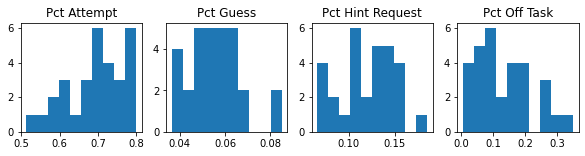

In [30]:
plt.figure(figsize=(10,2))
plt.subplot(141)
plt.hist(action_dist['Pct Attempt'], bins=10)
plt.title("Pct Attempt")

plt.subplot(142)
plt.hist(action_dist['Pct Guess'], bins=10)
plt.title("Pct Guess")

plt.subplot(143)
plt.hist(action_dist['Pct Hint Request'], bins=10)
plt.title("Pct Hint Request")

plt.subplot(144)
plt.hist(action_dist['Pct Off Task'], bins=10)
plt.title("Pct Off Task")

plt.show()

#### Learner Decisions EDA

In [31]:
# Get Learner actions
decisions = pd.DataFrame(db.decisions.find())
decisions['learner_knowledge'] = decisions['learner_knowledge'].apply(lambda x: x[0] if isinstance(x, Iterable) else x)
decisions['kcid'] = decisions['kc'].apply(lambda x: x['_id'])
decisions.head()

,_id,student_id,choice,time,action_evs,pev,problem,step,kc,learner_knowledge,attempt,hints_avail,hints_used,learner_off_task,self_eff,kcid
0,b678a539-d0be-4b22-a7d6-35cc04963521,5332323f-0421-4dd1-b901-83091a8ac9a8,HintRequest,2020-11-13 20:04:40.524,"{'Attempt': 11.836146940564696, 'Guess': 1.815...","[0.6615034435363488, 0.10147812964436534, 0.17...",9f64f057-5af4-4f06-aec8-79a2852178dc,ea76e6b2-50a9-4fe5-b047-f6560142b4ec,{'_id': '219c53ea-ba56-4768-b9fb-affbf6a54aa0'...,False,0,3,0,False,0.550383,219c53ea-ba56-4768-b9fb-affbf6a54aa0
1,417be220-c2d9-40c2-bf0e-7ae4bbfb7eb4,5332323f-0421-4dd1-b901-83091a8ac9a8,HintRequest,2020-11-13 20:04:44.568,"{'Attempt': 15.05919510965017, 'Guess': 1.0279...","[0.8346615200225274, 0.05697654789226309, 0.04...",9f64f057-5af4-4f06-aec8-79a2852178dc,ea76e6b2-50a9-4fe5-b047-f6560142b4ec,{'_id': '219c53ea-ba56-4768-b9fb-affbf6a54aa0'...,True,1,2,1,False,0.550383,219c53ea-ba56-4768-b9fb-affbf6a54aa0
2,8ff1439b-2f14-49b6-93f1-c685064d8738,5332323f-0421-4dd1-b901-83091a8ac9a8,Attempt,2020-11-13 20:04:46.146,"{'Attempt': 18.282243278735653, 'Guess': 0.724...","[0.8721719496391421, 0.03455831610749475, 0.03...",9f64f057-5af4-4f06-aec8-79a2852178dc,ea76e6b2-50a9-4fe5-b047-f6560142b4ec,{'_id': '219c53ea-ba56-4768-b9fb-affbf6a54aa0'...,True,2,1,2,False,0.550383,219c53ea-ba56-4768-b9fb-affbf6a54aa0
3,acfaaf5c-419a-479d-acf2-1f05209bd16f,5332323f-0421-4dd1-b901-83091a8ac9a8,Attempt,2020-11-13 20:05:10.003,"{'Attempt': 11.84580642558693, 'Guess': 1.0401...","[0.798178215663075, 0.07008612567341482, 0.051...",9f64f057-5af4-4f06-aec8-79a2852178dc,6c40d097-af6e-437e-8072-943cb341f983,{'_id': '219c53ea-ba56-4768-b9fb-affbf6a54aa0'...,True,0,3,0,False,0.550832,219c53ea-ba56-4768-b9fb-affbf6a54aa0
4,2db55e02-c894-40aa-9823-5db38efdb2e2,5332323f-0421-4dd1-b901-83091a8ac9a8,Guess,2020-11-13 20:05:25.460,"{'Attempt': 11.855446630199939, 'Guess': 0.936...","[0.8039172024531467, 0.06350783588079484, 0.05...",69bcd12f-aaf7-4dfe-a1cd-5b97e908febe,04502906-ce8e-46e6-8ce2-1fa8e702aa9f,{'_id': '219c53ea-ba56-4768-b9fb-affbf6a54aa0'...,True,0,3,0,False,0.551280,219c53ea-ba56-4768-b9fb-affbf6a54aa0


In [32]:
decisions[['problem', 'step', 'kcid', 'learner_knowledge', 'choice']].head(20)

,problem,step,kcid,learner_knowledge,choice
0,9f64f057-5af4-4f06-aec8-79a2852178dc,ea76e6b2-50a9-4fe5-b047-f6560142b4ec,219c53ea-ba56-4768-b9fb-affbf6a54aa0,False,HintRequest
1,9f64f057-5af4-4f06-aec8-79a2852178dc,ea76e6b2-50a9-4fe5-b047-f6560142b4ec,219c53ea-ba56-4768-b9fb-affbf6a54aa0,True,HintRequest
2,9f64f057-5af4-4f06-aec8-79a2852178dc,ea76e6b2-50a9-4fe5-b047-f6560142b4ec,219c53ea-ba56-4768-b9fb-affbf6a54aa0,True,Attempt
3,9f64f057-5af4-4f06-aec8-79a2852178dc,6c40d097-af6e-437e-8072-943cb341f983,219c53ea-ba56-4768-b9fb-affbf6a54aa0,True,Attempt
4,69bcd12f-aaf7-4dfe-a1cd-5b97e908febe,04502906-ce8e-46e6-8ce2-1fa8e702aa9f,219c53ea-ba56-4768-b9fb-affbf6a54aa0,True,Guess
5,69bcd12f-aaf7-4dfe-a1cd-5b97e908febe,04502906-ce8e-46e6-8ce2-1fa8e702aa9f,219c53ea-ba56-4768-b9fb-affbf6a54aa0,True,Guess
6,69bcd12f-aaf7-4dfe-a1cd-5b97e908febe,04502906-ce8e-46e6-8ce2-1fa8e702aa9f,219c53ea-ba56-4768-b9fb-affbf6a54aa0,True,HintRequest
7,69bcd12f-aaf7-4dfe-a1cd-5b97e908febe,04502906-ce8e-46e6-8ce2-1fa8e702aa9f,219c53ea-ba56-4768-b9fb-affbf6a54aa0,True,Attempt
8,69bcd12f-aaf7-4dfe-a1cd-5b97e908febe,c9e35ca5-dc4d-4912-aa91-0ae26622fd61,219c53ea-ba56-4768-b9fb-affbf6a54aa0,True,Attempt
9,69bcd12f-aaf7-4dfe-a1cd-5b97e908febe,18ddfe86-f1be-408d-a26f-f23782e509d7,219c53ea-ba56-4768-b9fb-affbf6a54aa0,True,Attempt


In [33]:
print(decisions['kc'][0])
print(decisions['action_evs'][0])
print(decisions['pev'][0])

{'_id': '219c53ea-ba56-4768-b9fb-affbf6a54aa0', 'domain_id': '64fbb4fb-c233-4e12-b463-a780240e7a36', 'pl0': 0.44252035332485107, 'pt': 0.47482913273012256, 'ps': 0.06158479309838702, 'pg': 0.4150845915506338, 'm_time': 23.743746330910348, 'sd_time': 5.935936582727587}
{'Attempt': 11.836146940564696, 'Guess': 1.815727590628004, 'HintRequest': 3.0477687224103946, 'OffTask': 1.1931539135431932}
[0.6615034435363488, 0.10147812964436534, 0.17033495064743315, 0.06668347617185272]


In [34]:
decision_kc_stats = decisions.groupby(['student_id', 'kcid'])['learner_knowledge'].agg(['count', 'sum'])
decision_kc_stats.head(50)

count  \
student_id                           kcid                                          
0309f6ac-9498-482c-bd32-0efcd5b5329f 000f2010-2c87-450e-b0fe-a1ce2e281af9     11   
                                     004d656c-f67b-4d44-96ac-79f969e65231     43   
                                     00f8e4f2-4a90-4626-b2a6-dcb3a539705d     14   
                                     014f1748-888d-4045-8f14-31531b63757e     12   
                                     0187f39b-2d33-41d1-9f67-407fc73528a3     10   
                                     0206b3b5-e703-4f30-8253-bb2cb4225fe7      7   
                                     02249cbe-ec19-4d19-b1a4-f5d9d73db916     50   
                                     02ffa25f-65aa-4feb-b308-4aa312d9410a     11   
                                     03447c72-11c2-4a61-be0b-f4aa9571da69     79   
                                     035a5d63-a4a8-44b9-bac6-3cd0fcc4d827     14   
                                     036286b6-50a7-437d-8105-ff3626744965      9   
                                     03e04a7e-ff51-4a1c-a405-67038f2f5c2d     10   
                                     042d94f9-8018-4f6f-9054-f0ca3f7fb94a     17   
                                     0451be3d-6790-41cb-96e0-0bdaed233c8a     11   
                                     046b6694-db26-423f-ab54-5c2a406bc38f      8   
                                     046c0b51-53be-46b7-b7a0-dd7a9b94ccd1      9   
                                     046f8598-657f-456b-882a-19b42db001c2     10   
                                     04c93750-9b5f-43ff-948d-9c535607d0af    118   
                                     04ce0914-b214-4770-83ff-935019b9816f     13   
                                     04edc0a5-31c3-421e-931d-1190d2e7d63b     12   
                                     051d9f32-bb57-41cf-996f-90d14770c3cb     11   
                                     0529c0f4-40b1-4163-aee3-bf6da7c630d6     13   
                                     053b4770-e720-48fc-847f-ea601ae30e95     15   
                                     05449009-4366-42da-a2d9-42e7f030b18b      7   
                                     0544bdd4-8704-434a-91cd-d9e83fe35d38      6   
                                     05742dbe-a4b8-4549-97ae-48d966dea366     13   
                                     05768842-0c38-4280-95ca-05baea1a1b40     15   
                                     05ae52ad-e87c-4089-9680-7c1d065aab2d     15   
                                     05b567cd-9e55-4ec1-96a3-b5671ec1c4b6     11   
                                     062151ba-aea4-4b51-b9e2-5e2d190006e9     17   
                                     063bb7ba-c12b-415c-a066-19c090c9882e      4   
                                     0663883a-06a7-435f-838c-2add699d9a41     11   
                                     066d0bb5-bc0b-4679-98cc-50d238fa3978      7   
                                     066f56ca-2d60-4b80-b520-ad18fe7e5d07     15   
                                     06f5d6f8-85ac-4513-a84b-16ec5a7c56f0     11   
                                     07121389-2110-4bb1-b5f8-bca12b429aa0      8   
                                     097cce82-dc1d-4321-8f54-f3f29d54c72f      9   
                                     0acaab58-ca5d-4279-9356-3b156b960062     13   
                                     0ad15152-a60b-4584-aacc-50fe9ed067d2     13   
                                     0b53ffbf-490d-4749-8630-aa170e51d004     11   
                                     0ba0354d-1470-4b75-aed3-4aa0b1738d27     31   
                                     0baf0b6d-c150-4044-91d2-42596f11901f      4   
                                     0c39b8b2-ce58-4e61-95b1-55c5ef2df570     20   
                                     0c743890-8580-4fc3-9def-1cb4cbabbe84     10   
                                     0cec0a74-e317-4b6c-b998-41b1260e0685    100   
                                     0cf65ab3-de40-4030-baf4-675d06927c1f     27   
                                     0d1780

#### Learner Transactions EDA

In [35]:
# Get learner transactions
tx = pd.DataFrame(db.tutor_events.find({'type': "Tutor Input"}))
logger.info("Learner Transactions: %s" % str(tx.shape))
tx.head()

INFO:main:Learner Transactions: (470030, 17)


,_id,type,time,curric_id,unit_id,section_id,prob_id,step_id,stu_id,duration,outcome,kcs,plt,plt1,hints_used,hints_avail,attempt
0,0f2db992-e2ad-43d2-8831-b01ef1f83c04,Tutor Input,2020-11-13 20:04:44.568,5b7d4068-4287-4585-a705-8ea1a72f4761,28660318-8fc7-4568-8c13-aa412261927d,2649cdbc-2676-4ffe-8e62-fd8c2544444d,9f64f057-5af4-4f06-aec8-79a2852178dc,ea76e6b2-50a9-4fe5-b047-f6560142b4ec,5332323f-0421-4dd1-b901-83091a8ac9a8,4.044265,Hint,[{'_id': '219c53ea-ba56-4768-b9fb-affbf6a54aa0...,0.442520,0.515336,0,3,0
1,9952babc-01c8-44d9-898d-28f70a99c3e5,Tutor Input,2020-11-13 20:04:46.146,5b7d4068-4287-4585-a705-8ea1a72f4761,28660318-8fc7-4568-8c13-aa412261927d,2649cdbc-2676-4ffe-8e62-fd8c2544444d,9f64f057-5af4-4f06-aec8-79a2852178dc,ea76e6b2-50a9-4fe5-b047-f6560142b4ec,5332323f-0421-4dd1-b901-83091a8ac9a8,1.577746,Hint,[{'_id': '219c53ea-ba56-4768-b9fb-affbf6a54aa0...,0.515336,0.515336,1,2,1
2,02160b6e-dc3f-4ff0-b384-2ab063596443,Tutor Input,2020-11-13 20:05:10.003,5b7d4068-4287-4585-a705-8ea1a72f4761,28660318-8fc7-4568-8c13-aa412261927d,2649cdbc-2676-4ffe-8e62-fd8c2544444d,9f64f057-5af4-4f06-aec8-79a2852178dc,ea76e6b2-50a9-4fe5-b047-f6560142b4ec,5332323f-0421-4dd1-b901-83091a8ac9a8,23.857322,Correct,[{'_id': '219c53ea-ba56-4768-b9fb-affbf6a54aa0...,0.515336,0.515336,2,1,2
3,819c8b8f-7ac7-4999-bd85-a88ad7578b5c,Tutor Input,2020-11-13 20:05:25.460,5b7d4068-4287-4585-a705-8ea1a72f4761,28660318-8fc7-4568-8c13-aa412261927d,2649cdbc-2676-4ffe-8e62-fd8c2544444d,9f64f057-5af4-4f06-aec8-79a2852178dc,6c40d097-af6e-437e-8072-943cb341f983,5332323f-0421-4dd1-b901-83091a8ac9a8,15.456750,Correct,[{'_id': '219c53ea-ba56-4768-b9fb-affbf6a54aa0...,0.515336,0.845713,0,3,0
4,31d6718e-6330-4fd3-89fb-144749adbea6,Tutor Input,2020-11-13 20:05:28.448,5b7d4068-4287-4585-a705-8ea1a72f4761,28660318-8fc7-4568-8c13-aa412261927d,2649cdbc-2676-4ffe-8e62-fd8c2544444d,69bcd12f-aaf7-4dfe-a1cd-5b97e908febe,04502906-ce8e-46e6-8ce2-1fa8e702aa9f,5332323f-0421-4dd1-b901-83091a8ac9a8,2.988336,Incorrect,[{'_id': '219c53ea-ba56-4768-b9fb-affbf6a54aa0...,0.845713,0.667008,0,3,0


In [36]:
# Add kc field that reduces list of kcs to 1 kc
tx['kc'] = tx.apply(lambda x: x['kcs'][0]['_id'], axis=1)

In [37]:
# Aggregate Learner transaction stats

# Total Transaction counts
stu_stats = tx.groupby('stu_id').agg({'_id': 'count', 
                                      'duration': np.sum,
                                     })
stu_stats.rename(columns={'_id': "Total Tx",
                          'duration': 'Total Time'}, 
                         inplace = True)
stu_stats['Total Time(hours)'] = stu_stats['Total Time'].apply(lambda x: x / 3600)
logger.info("Number of students: %i" % stu_stats.shape[0])
logger.info(stu_stats["Total Tx"].describe())

# Total of each outcome
d = tx.groupby(['stu_id','outcome'])['_id'].count().reset_index().pivot(index='stu_id', columns='outcome', values='_id')

# Prorporation of each outcome
stu_stats = pd.concat([stu_stats, d], axis=1)
stu_stats['Pct Correct'] = stu_stats['Correct'] / stu_stats['Total Tx']
stu_stats['Pct Hint'] = stu_stats['Hint'] / stu_stats['Total Tx']
stu_stats['Pct Incorrect'] = stu_stats['Incorrect'] / stu_stats['Total Tx']


logger.info(stu_stats.shape)

logger.info(stu_stats.columns)



INFO:main:Number of students: 30
INFO:main:count       30.000000
mean     15667.666667
std       1745.559555
min      12139.000000
25%      14775.750000
50%      15668.500000
75%      16830.500000
max      18960.000000
Name: Total Tx, dtype: float64
INFO:main:(30, 9)
INFO:main:Index(['Total Tx', 'Total Time', 'Total Time(hours)', 'Correct', 'Hint',
       'Incorrect', 'Pct Correct', 'Pct Hint', 'Pct Incorrect'],
      dtype='object')


In [38]:
# Attempts per step


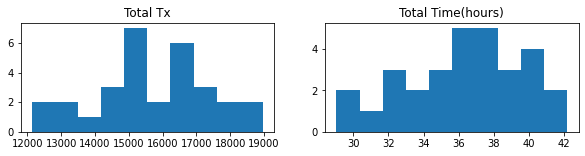

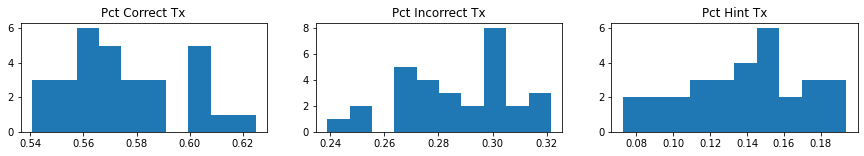

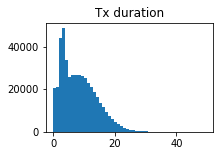

In [39]:
plt.figure(figsize=(10,2))
plt.subplot(121)
plt.hist(stu_stats['Total Tx'], bins=10)
plt.title("Total Tx")

plt.subplot(122)
plt.hist(stu_stats['Total Time(hours)'], bins=10)
plt.title("Total Time(hours)")
plt.show()

plt.figure(figsize=(15,2))
plt.subplot(131)
plt.hist(stu_stats['Pct Correct'], bins=10)
plt.title("Pct Correct Tx")

plt.subplot(132)
plt.hist(stu_stats['Pct Incorrect'], bins=10)
plt.title("Pct Incorrect Tx")

plt.subplot(133)
plt.hist(stu_stats['Pct Hint'], bins=10)
plt.title("Pct Hint Tx")
plt.show()

plt.figure(figsize=(3,2))
plt.hist(tx['duration'],bins=50)
plt.title("Tx duration")
plt.show()

In [40]:
step_stats = tx.groupby(['stu_id', 'unit_id', 'section_id', 'prob_id', 'step_id'])['duration'].agg(['sum', 'count']).reset_index()
stu_prob_stats = step_stats.groupby('stu_id')['count'].describe()
stu_prob_stats.columns = ["Step Attempt %s" % col for col in stu_prob_stats.columns]
d = step_stats.groupby('stu_id')['sum'].describe()
d.columns = ["Step Duration %s" % col for col in d.columns]
stu_prob_stats = pd.concat([stu_prob_stats, d], axis=1)
stu_prob_stats.head()

# kc_stats = tx[['stu_id', 'kc', 'step_id']].drop_duplicates().groupby(['stu_id', 'kc']).count()
stu_kc_stats = tx[['stu_id', 'kc', 'step_id']].drop_duplicates().groupby(['stu_id', 'kc']).count().reset_index()
stu_kc_stats.rename(columns={'step_id': 'kc opportunities'}, inplace=True)
kc_stats = stu_kc_stats.groupby('kc').describe()

#prob_stats = tx.groupby(['stu_id', 'unit_id', 'section_id', 'prob_id'])['duration'].count().reset_index()
#section_stats = step_stats.groupby(['stu_id', 'unit_id', 'section_id'])['sum'].agg(['count', np.mean, np.std])
#unit_stats = step_stats.groupby(['stu_id', 'unit_id'])['sum'].agg(['count', np.mean, np.std])


In [41]:
# Number of transactions with negative duration
# This is a sanity check
count = np.sum(tx['duration'] < 0)
logger.info("Number of transactions with negative duration: %i out of %i(%.2f%%)" % (count, tx.shape[0], count * 100 / tx.shape[0]))

INFO:main:Number of transactions with negative duration: 0 out of 470030(0.00%)


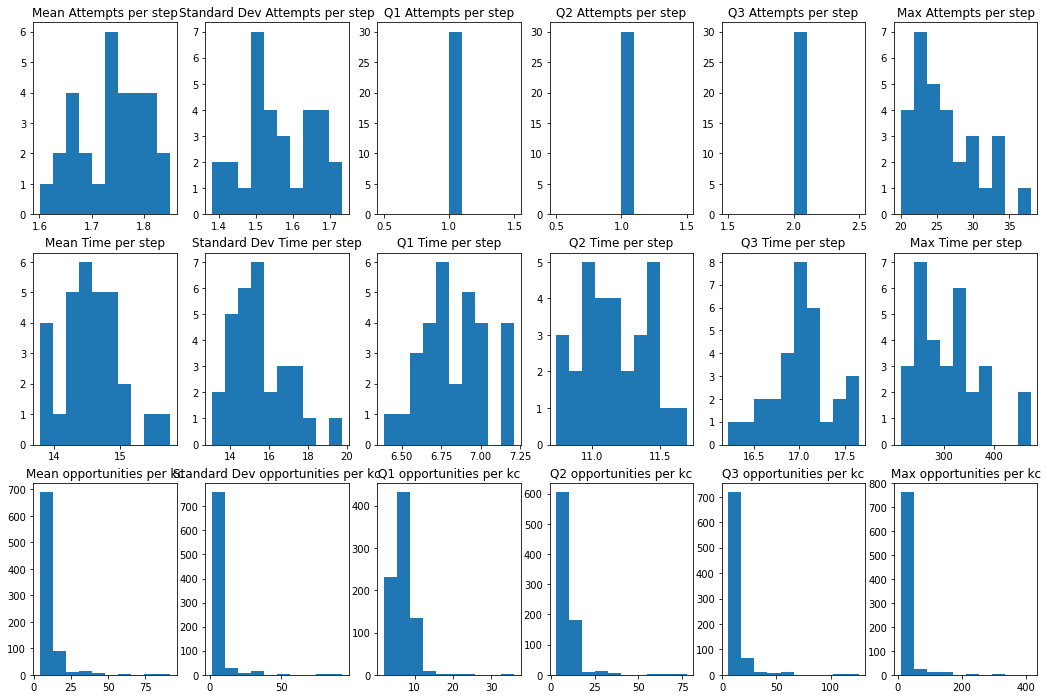

In [42]:
num_bins = 10
num_rows = 3
num_cols = 6
row_height = 3
col_width = 3
plt.figure(figsize=(col_width*num_cols, row_height*num_rows+num_rows))

row = 0
plt.subplot(num_rows,num_cols,num_cols*row + 1)
plt.hist(stu_prob_stats['Step Attempt mean'], bins=num_bins)
plt.title("Mean Attempts per step")
plt.subplot(num_rows,num_cols,num_cols*row + 2)
plt.hist(stu_prob_stats['Step Attempt std'], bins=num_bins)
plt.title("Standard Dev Attempts per step")


plt.subplot(num_rows,num_cols,num_cols*row + 3)
plt.hist(stu_prob_stats['Step Attempt 25%'], bins=num_bins)
plt.title("Q1 Attempts per step")
plt.subplot(num_rows,num_cols,num_cols*row + 4)
plt.hist(stu_prob_stats['Step Attempt 50%'], bins=num_bins)
plt.title("Q2 Attempts per step")
plt.subplot(num_rows,num_cols,num_cols*row + 5)
plt.hist(stu_prob_stats['Step Attempt 75%'], bins=num_bins)
plt.title("Q3 Attempts per step")
plt.subplot(num_rows,num_cols,num_cols*row + 6)
plt.hist(stu_prob_stats['Step Attempt max'], bins=num_bins)
plt.title("Max Attempts per step")

row = 1
plt.subplot(num_rows,num_cols,num_cols*row + 1)
plt.hist(stu_prob_stats['Step Duration mean'], bins=num_bins)
plt.title("Mean Time per step")
plt.subplot(num_rows,num_cols,num_cols*row + 2)
plt.hist(stu_prob_stats['Step Duration std'], bins=num_bins)
plt.title("Standard Dev Time per step")


plt.subplot(num_rows,num_cols,num_cols*row + 3)
plt.hist(stu_prob_stats['Step Duration 25%'], bins=num_bins)
plt.title("Q1 Time per step")
plt.subplot(num_rows,num_cols,num_cols*row + 4)
plt.hist(stu_prob_stats['Step Duration 50%'], bins=num_bins)
plt.title("Q2 Time per step")
plt.subplot(num_rows,num_cols,num_cols*row + 5)
plt.hist(stu_prob_stats['Step Duration 75%'], bins=num_bins)
plt.title("Q3 Time per step")
plt.subplot(num_rows,num_cols,num_cols*row + 6)
plt.hist(stu_prob_stats['Step Duration max'], bins=num_bins)
plt.title("Max Time per step")

row = 2
plt.subplot(num_rows,num_cols,num_cols*row + 1)
plt.hist(kc_stats[('kc opportunities', 'mean')], bins=num_bins)
plt.title("Mean opportunities per kc")
plt.subplot(num_rows,num_cols,num_cols*row + 2)
plt.hist(kc_stats[('kc opportunities', 'std')], bins=num_bins)
plt.title("Standard Dev opportunities per kc")


plt.subplot(num_rows,num_cols,num_cols*row + 3)
plt.hist(kc_stats[('kc opportunities', '25%')], bins=num_bins)
plt.title("Q1 opportunities per kc")
plt.subplot(num_rows,num_cols,num_cols*row + 4)
plt.hist(kc_stats[('kc opportunities', '50%')], bins=num_bins)
plt.title("Q2 opportunities per kc")
plt.subplot(num_rows,num_cols,num_cols*row + 5)
plt.hist(kc_stats[('kc opportunities', '75%')], bins=num_bins)
plt.title("Q3 opportunities per kc")
plt.subplot(num_rows,num_cols,num_cols*row + 6)
plt.hist(kc_stats[('kc opportunities', 'max')], bins=num_bins)
plt.title("Max opportunities per kc")

plt.show()


### Student to behavior EDA

In [43]:
# Merge behavioral stats with generated student measures
stus = pd.merge(sim_students, stu_stats, how='inner', left_on='_id', right_on=stu_stats.index)
logger.debug(stus.shape)
stus = pd.merge(stus, action_dist, how='inner', left_on='_id', right_on=action_dist.index)
for col in stus['values'][0].keys():
    stus['%s value' % col]  = stus.apply(lambda x: x['values'][col], axis=1)
logger.debug(stus.shape)
stus.head()

,_id,domain_id,type,skills,min_off_task,max_off_task,mean_guess_time,sd_guess_time,diligence,self_eff,...,Off Task,total,Pct Attempt,Pct Guess,Pct Hint Request,Pct Off Task,attempt value,guess value,hint request value,off task value
0,5332323f-0421-4dd1-b901-83091a8ac9a8,64fbb4fb-c233-4e12-b463-a780240e7a36,Self Efficacy Learner,{'219c53ea-ba56-4768-b9fb-affbf6a54aa0': False...,30,1200,3,1,1.812376,0.550383,...,1088,15821,0.785412,0.065483,0.080336,0.068769,11.865801,9.051075,1.681643,1.193154
1,581d09e0-be83-42b4-ad9c-7ed101ce0d66,64fbb4fb-c233-4e12-b463-a780240e7a36,Self Efficacy Learner,{'219c53ea-ba56-4768-b9fb-affbf6a54aa0': False...,30,1200,3,1,1.440692,0.440657,...,3983,21703,0.611390,0.062526,0.142561,0.183523,10.493506,8.049886,4.306476,2.999050
2,70ab2726-e587-4d52-be61-1673c47c0ddd,64fbb4fb-c233-4e12-b463-a780240e7a36,Self Efficacy Learner,"{'219c53ea-ba56-4768-b9fb-affbf6a54aa0': True,...",30,1200,3,1,2.394740,0.493820,...,4788,16992,0.608698,0.041137,0.068385,0.281780,11.101604,8.732496,1.812863,7.834315
3,3d0b70dd-c386-4edd-a8b8-2d3b8734c7c3,64fbb4fb-c233-4e12-b463-a780240e7a36,Self Efficacy Learner,{'219c53ea-ba56-4768-b9fb-affbf6a54aa0': False...,30,1200,3,1,1.999051,0.673845,...,322,16729,0.775241,0.064678,0.140833,0.019248,10.812704,9.585422,3.111035,0.345954
4,944334f9-4356-495f-8620-95261c2e0b2d,64fbb4fb-c233-4e12-b463-a780240e7a36,Self Efficacy Learner,{'219c53ea-ba56-4768-b9fb-affbf6a54aa0': False...,30,1200,3,1,1.836901,0.445446,...,5755,22644,0.574236,0.055070,0.116543,0.254151,10.720705,10.343442,3.714500,5.799801


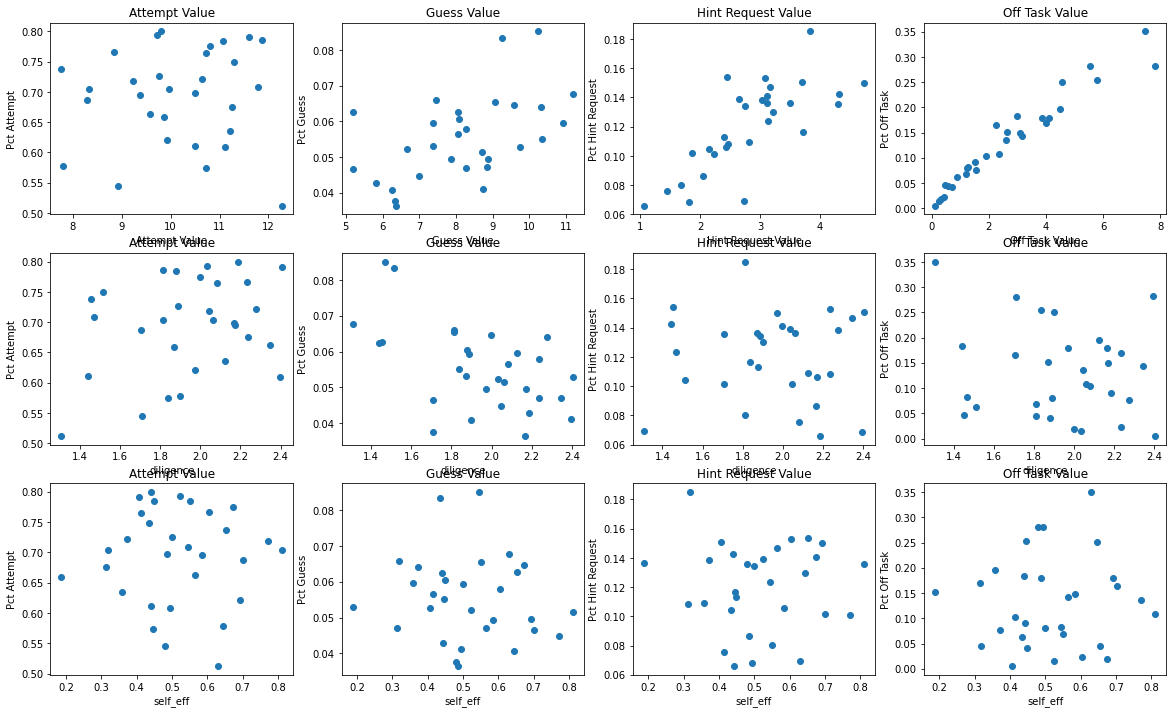

In [44]:
# Value vs action
num_bins = 10
num_rows = 3
num_cols = 4
row_height = 3
col_width = 5
plt.figure(figsize=(col_width*num_cols, row_height*num_rows+num_rows))

row = 0
plt.subplot(num_rows,num_cols,num_cols*row + 1)
plt.scatter(stus['attempt value'], stus['Pct Attempt'])
plt.title("Attempt Value")
plt.xlabel("Attempt Value")
plt.ylabel("Pct Attempt")

plt.subplot(num_rows,num_cols,num_cols*row + 2)
plt.scatter(stus['guess value'], stus['Pct Guess'])
plt.title("Guess Value")
plt.xlabel("Guess Value")
plt.ylabel("Pct Guess")


plt.subplot(num_rows,num_cols,num_cols*row + 3)
plt.scatter(stus['hint request value'], stus['Pct Hint Request'])
plt.title("Hint Request Value")
plt.xlabel("Hint Request Value")
plt.ylabel("Pct Hint Request")

plt.subplot(num_rows,num_cols,num_cols*row + 4)
plt.scatter(stus['off task value'], stus['Pct Off Task'])
plt.title("Off Task Value")
plt.xlabel("Off Task Value")
plt.ylabel("Pct Off Task")

row = 1
xcol='diligence'
plt.subplot(num_rows,num_cols,num_cols*row + 1)
plt.scatter(stus[xcol], stus['Pct Attempt'])
plt.title("Attempt Value")
plt.xlabel(xcol)
plt.ylabel("Pct Attempt")

plt.subplot(num_rows,num_cols,num_cols*row + 2)
plt.scatter(stus[xcol], stus['Pct Guess'])
plt.title("Guess Value")
plt.xlabel(xcol)
plt.ylabel("Pct Guess")


plt.subplot(num_rows,num_cols,num_cols*row + 3)
plt.scatter(stus[xcol], stus['Pct Hint Request'])
plt.title("Hint Request Value")
plt.xlabel(xcol)
plt.ylabel("Pct Hint Request")

plt.subplot(num_rows,num_cols,num_cols*row + 4)
plt.scatter(stus[xcol], stus['Pct Off Task'])
plt.title("Off Task Value")
plt.xlabel(xcol)
plt.ylabel("Pct Off Task")

row = 2
xcol='self_eff'
plt.subplot(num_rows,num_cols,num_cols*row + 1)
plt.scatter(stus[xcol], stus['Pct Attempt'])
plt.title("Attempt Value")
plt.xlabel(xcol)
plt.ylabel("Pct Attempt")

plt.subplot(num_rows,num_cols,num_cols*row + 2)
plt.scatter(stus[xcol], stus['Pct Guess'])
plt.title("Guess Value")
plt.xlabel(xcol)
plt.ylabel("Pct Guess")


plt.subplot(num_rows,num_cols,num_cols*row + 3)
plt.scatter(stus[xcol], stus['Pct Hint Request'])
plt.title("Hint Request Value")
plt.xlabel(xcol)
plt.ylabel("Pct Hint Request")

plt.subplot(num_rows,num_cols,num_cols*row + 4)
plt.scatter(stus[xcol], stus['Pct Off Task'])
plt.title("Off Task Value")
plt.xlabel(xcol)
plt.ylabel("Pct Off Task")


plt.show()


In [45]:
for col in stus.columns:
    print(col)

_id
domain_id
type
skills
min_off_task
max_off_task
mean_guess_time
sd_guess_time
diligence
self_eff
values
total_attempts
total_success
final skills
final total attempts
final total success
pre-sim total mastery
final-sim total mastery
total skills
pre-sim pct mastery
final-sim pct mastery
final-sim total unmastered
final self-eff
pct success
Total Tx
Total Time
Total Time(hours)
Correct
Hint
Incorrect
Pct Correct
Pct Hint
Pct Incorrect
Attempt
Guess
Hint Request
Off Task
total
Pct Attempt
Pct Guess
Pct Hint Request
Pct Off Task
attempt value
guess value
hint request value
off task value


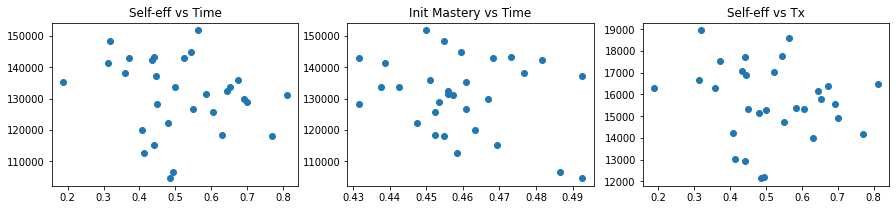

In [46]:
plt.figure(figsize=(15,3))
plt.subplot(1,3,1)
plt.scatter(stus['self_eff'], stus['Total Time'])
plt.title("Self-eff vs Time")

plt.subplot(1,3,2)
plt.scatter(stus['pre-sim pct mastery'], stus['Total Time'])
plt.title("Init Mastery vs Time")


plt.subplot(1,3,3)
plt.scatter(stus['self_eff'], stus['Total Tx'])
plt.title("Self-eff vs Tx")

plt.show()
